In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dfShootings = pd.read_csv('../datasets/shootings.csv')
usPop = pd.read_csv('../datasets/acs2017_census_tract_data.csv')

In [3]:
usPop['Other'] = round(100 - usPop['Hispanic'] - usPop['White'] - usPop['Black'] - usPop['Native'] - usPop['Asian'], 2)
orderedRace = ['White','Black','Hispanic','Asian','Native','Other']

usRacePop = pd.DataFrame(columns = [])
arrayRacePop = []
mortalityPerMillion = []
usTotalPop = usPop['TotalPop'].sum()

for item in orderedRace:
    usRacePop[item + 'Pop'] = round(usPop[item] * usPop['TotalPop'] / 100)
    arrayRacePop.append(round(usRacePop[item+'Pop'].sum() / usTotalPop, 4))
    
arrayRacePop

[0.6081, 0.1216, 0.1847, 0.0524, 0.0065, 0.0268]

In [4]:
dfBlack = dfShootings[dfShootings['race'] == 'Black'].reset_index(drop=True)
blackProp = len(dfBlack) / len(dfShootings)
dfShootings

,id,name,date,manner_of_death,armed,age,gender,race,city,state,signs_of_mental_illness,threat_level,flee,body_camera,arms_category
0,3,Tim Elliot,2015-01-02,shot,gun,53.000000,M,Asian,Shelton,WA,True,attack,Not fleeing,False,Guns
1,4,Lewis Lee Lembke,2015-01-02,shot,gun,47.000000,M,White,Aloha,OR,False,attack,Not fleeing,False,Guns
2,5,John Paul Quintero,2015-01-03,shot and Tasered,unarmed,23.000000,M,Hispanic,Wichita,KS,False,other,Not fleeing,False,Unarmed
3,8,Matthew Hoffman,2015-01-04,shot,toy weapon,32.000000,M,White,San Francisco,CA,True,attack,Not fleeing,False,Other unusual objects
4,9,Michael Rodriguez,2015-01-04,shot,nail gun,39.000000,M,Hispanic,Evans,CO,False,attack,Not fleeing,False,Piercing objects
5,11,Kenneth Joe Brown,2015-01-04,shot,gun,18.000000,M,White,Guthrie,OK,False,attack,Not fleeing,False,Guns
6,13,Kenneth Arnold Buck,2015-01-05,shot,gun,22.000000,M,Hispanic,Chandler,AZ,False,attack,Car,False,Guns
7,15,Brock Nichols,2015-01-06,shot,gun,35.000000,M,White,Assaria,KS,False,attack,Not fleeing,False,Guns
8,16,Autumn Steele,2015-01-06,shot,unarmed,34.000000,F,White,Burlington,IA,False,other,Not fleeing,True,Unarmed
9,17,Leslie Sapp III,2015-01-06,shot,toy weapon,47.000000,M,Black,Knoxville,PA,False,attack,Not fleeing,False,Other unusual objects


In [5]:
propSample = []
propSample = list(dfShootings['race'].value_counts() / len(dfShootings))
propSample

[0.5058222676200205,
 0.2651685393258427,
 0.1842696629213483,
 0.018998978549540347,
 0.015934627170582225,
 0.009805924412665985]

Text(0, 0.5, 'Grupo')

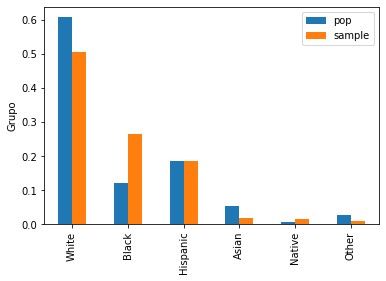

In [6]:
df = pd.DataFrame(index=orderedRace)
df['pop'] = arrayRacePop
df['sample'] = propSample

df.plot.bar()
plt.ylabel('Propopção')
plt.ylabel('Grupo')

In [7]:
def total_variation(p, q):
    return np.sum(np.abs(p - q)) / 2

originalTVD = total_variation(df['pop'], df['sample'])

In [8]:
def sample_proportion(pop_size, prop, n=10000):
    grupo = pop_size * prop
    resultados = np.zeros(n)
    for i in range(n):
        sample = np.random.randint(0, pop_size, 100)
        resultados[i] = np.sum(sample < grupo)
    return resultados

In [9]:
N = len(dfShootings)

A = np.zeros(shape=(10000, len(df.index)))
for i, g in enumerate(df.index):
    p = df.loc[g]['pop']
    print(g)
    A[:, i] = sample_proportion(N, p) / 100

White
Black
Hispanic
Asian
Native
Other


In [10]:
all_distances = []
for i in range(A.shape[0]):
    all_distances.append(total_variation(df['pop'], A[i]))

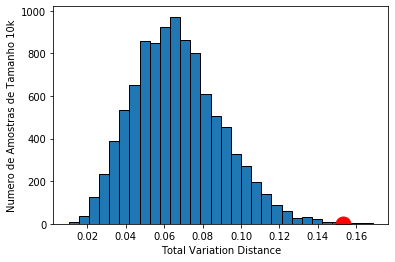

In [11]:
plt.hist(all_distances, bins=30, edgecolor='k')
plt.ylabel('Numero de Amostras de Tamanho 10k')
plt.xlabel('Total Variation Distance')
plt.plot(originalTVD, [0], 'ro', ms=15)

In [12]:
inferior, superior = np.percentile(all_distances, 2.5), np.percentile(all_distances, 97.5)
superior

0.11574999999999998

In [13]:
#Questao B: O proporção de mortes dos 25 estados com mais armas é igual a dos outros 25 estados

In [14]:
deathsArmedStates = dfShootings.groupby(['state']).size()
deathsArmedStates = pd.DataFrame(deathsArmedStates)
deathsArmedStates = deathsArmedStates.rename(columns = {0: 'Deaths'})
deathsArmedStates['APP'] = 0
deathsArmedStates.loc[['AK','AR','ID','WV','WY','MT','NM','AL','ND','HI','LA','SC','MS','KY','TN','NV','MN','TX','SD','WI','CO','IA','IN','FL','AZ'],'APP'] = 1
deathsArmedStates = deathsArmedStates.groupby(['APP']).sum()

#Filtrando a população dos 25 estados mais armados
statePop = usPop.groupby(['State']).sum()
statePop = statePop[['TotalPop']]
statePop['APP'] = 0
statePop.loc[['Alaska','Arkansas','Idaho','West Virginia','Wyoming','Montana','New Mexico','Alabama','North Dakota','Hawaii','Louisiana','South Carolina','Mississippi','Kentucky','Tennessee','Nevada','Minnesota','Texas','South Dakota','Wisconsin','Colorado','Iowa','Indiana','Florida','Arizona'],'APP'] = 1
selectStatePop = statePop.groupby(['APP']).sum()


#1º Linha: Estados MENOS armados; 2ª Linha: Estados MAIS armados
deathsArmedStates['StatePop'] = selectStatePop['TotalPop']
deathsArmedStates['TotalPopProportion'] = deathsArmedStates['StatePop'] / usTotalPop
deathsArmedStates['DeathsPerMilion'] = (deathsArmedStates['Deaths']/deathsArmedStates['StatePop'])*1000000
deathsArmedStates


,Deaths,StatePop,TotalPopProportion,DeathsPerMilion
APP,,,,
0,2469,198307811,0.611168,12.450342
1,2426,126165559,0.388832,19.228703


In [15]:
t_obs = deathsArmedStates.loc[1]['DeathsPerMilion'] - deathsArmedStates.loc[0]['DeathsPerMilion']
t_obs

6.778360845941998

In [16]:
statePopRandom = statePop.copy()
N = 10000
diferencas = np.zeros(N)

for i in range(N):
    np.random.shuffle(statePopRandom['APP'].values)
    selectStateRandom = statePopRandom.groupby(['APP']).sum()
    
    deathsArmedStates['StatePop'] = selectStateRandom['TotalPop']
    deathsArmedStates['DeathsPerMilion'] = (deathsArmedStates['Deaths']/deathsArmedStates['StatePop'])*1000000
    
    diff = deathsArmedStates.loc[1]['DeathsPerMilion'] - deathsArmedStates.loc[0]['DeathsPerMilion']
    diferencas[i] = diff
diferencas

array([2.09975132, 8.66702838, 3.29467813, ..., 8.86662016, 8.94736222,
       0.30882573])

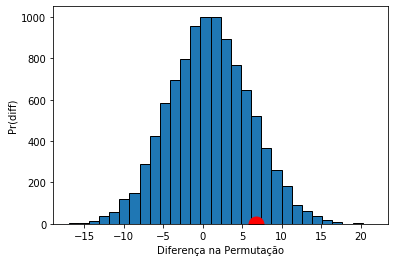

In [17]:
plt.hist(diferencas, bins=30, edgecolor='k')
plt.xlabel('Diferença na Permutação')
plt.ylabel('Pr(diff)')

plt.plot(t_obs, [0], 'ro', ms=15)

In [20]:
inferior, superior = np.percentile(diferencas, 2.5), np.percentile(diferencas, 97.5)
superior

10.995844465748904